# Modeling and Simulation in Python

Project 2

Maalvika Bhat & Richard Gao

In [236]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [237]:
# Calculate the heat necessary to melt .05 kg of ice
m_solid = .05
latent_heat_fusion = 3.3 * 10 ** 5
q = m_solid * latent_heat_fusion

16500.0

In [238]:
human_specific_heat_capacity = 3500
mass_hand = 70 * 0.58 # Avg human male is 70kg and hand takes up 0.58% of body weight

40.599999999999994

In [239]:
# Specify material information
material_info = {'material': ['aluminum', 'nickel', 'marble', 'wood'],
                 'thermal_conductivity_factor': [205, 91, 2.5, 0.16],
                 'specific_heat_capacity': [897, 461, 880, 2000],
                 'density': [2700, 8908, 2570, 240]}

plate_materials = pd.DataFrame(material_info,
                              columns=['material','thermal_conductivity_factor', 'specific_heat_capacity', 'density'])

,material,thermal_conductivity_factor,specific_heat_capacity,density
0,aluminum,205.00,897,2700
1,nickel,91.00,461,8908
2,marble,2.50,880,2570
3,wood,0.16,2000,240


In [240]:
def make_system(params):
    """Makes a System object with the given parameters held within the params object.
    
    params:
        material: type of material as a string
        plate_materials: dataframe of recorded material information 
                         (name, thermal conductivity factor, 
                          specific heat capacity, density)
        surface_area: area of plate in contact with ice, in meters^2
        plate_temp: temperature of the plate, in celsius 
        thickness: thickness of the plate, in meters
        dt: time interval, in seconds
    
    returns: System object
    """
    material, plate_materials, surface_area, hand_temp, thickness, dt = params
    
    # Assumption that the thermal energy in hand is unlimited as long as the human keeps eating, therefore
    # thermal_energy_hand is set to a random large number
    init = State(thermal_energy_hand = 100000, 
                 thermal_energy_ice = 0,
                 hand_temp=hand_temp)
    
    t0 = 0
    dt = dt
    
    return System(locals())

In [241]:
def update_func(state, system):
    """Update the ice-plate-hand melting model.
    
    state: State
    system: System object
    
    returns: State
    """
    unpack(system)
    thermal_energy_hand, thermal_energy_ice, hand_temp = state
    
    index = pd.Index(plate_materials['material']).get_loc(material)
    
    thermal_conductivity_factor = plate_materials['thermal_conductivity_factor'][index]
    specific_heat_capacity = plate_materials['specific_heat_capacity'][index]
    
    #-------Calulating mass---------
    # mass is dependent on the parameters surface_area and thickness and material type, m=V*p
    density = plate_materials['density'][index]
    mass = (surface_area * thickness) * density
    
    #------Calculating heat (flows)-------
#     hand_to_plate = mass * specific_heat_capacity * (hand_temp - plate_temp) * dt
#     plate_to_ice = (thermal_conductivity_factor * surface_area * plate_temp / thickness) * dt
#     hand_to_plate = mass * specific_heat_capacity * (hand_temp - plate_temp) * dt
#     # does not take into account the plate temperature effect on ice
#     hand_to_ice = (thermal_conductivity_factor * surface_area * hand_temp / thickness) * dt 
    
    hand_to_ice = (thermal_conductivity_factor * surface_area * hand_temp / thickness)
    
#     print('hand_to_plate', hand_to_plate)
#     print('hand_to_ice', hand_to_ice)
#     print('total q', (hand_to_plate + hand_to_ice))
#     print('----------')

    
    #------Euler's method--------
#     thermal_energy_hand -= (hand_to_plate + hand_to_ice) 
#     thermal_energy_ice += hand_to_ice 
    thermal_energy_hand -= hand_to_ice * dt
    thermal_energy_ice += hand_to_ice * dt
    
#     print(hand_temp)
    
#     #-------Changing hand temperature---------
#     # TODO: change hand temp so it's not a constant but variable in temperature
    hand_temp -= hand_to_ice / (human_specific_heat_capacity * mass_hand)  
    
    #------Changing plate temperature-------
    # We've abstracted the scenario to not take convection or radiation into account
#     deltaQ = hand_to_plate - plate_to_ice
#     plate_temp += deltaQ / (specific_heat_capacity * mass)
#     plate_temp += hand_to_plate / (specific_heat_capacity * mass)
    
    return State(thermal_energy_hand=thermal_energy_hand,
                 thermal_energy_ice=thermal_energy_ice,
                 hand_temp=hand_temp)

In [242]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    # Runs simulation until ice has completely melted -> thermal_energy_ice surpasses heat necessary to melt ice q
    melted = False
    t = 0
    while not melted:
        new_state = update_func(frame.row[t], system)
        if new_state.thermal_energy_ice >= q:
            melted = True
        else:
            t = round(t + dt, 3)
            frame.row[t] = new_state
            print(frame.row[t])
        
    return frame

In [243]:
params = Params(material='aluminum',
                plate_materials=plate_materials,
                surface_area=.05,
                hand_temp=37,
                thickness=.02,
                dt=.1)
system = make_system(params)
results = run_simulation(system, update_func)

thermal_energy_hand    98103.8
thermal_energy_ice     1896.25
hand_temp              36.8666
Name: 0.1, dtype: object
thermal_energy_hand    96214.3
thermal_energy_ice     3785.66
hand_temp              36.7336
Name: 0.2, dtype: object
thermal_energy_hand    94331.7
thermal_energy_ice     5668.26
hand_temp              36.6011
Name: 0.3, dtype: object
thermal_energy_hand    92455.9
thermal_energy_ice     7544.06
hand_temp              36.4691
Name: 0.4, dtype: object
thermal_energy_hand    90586.9
thermal_energy_ice     9413.11
hand_temp              36.3376
Name: 0.5, dtype: object
thermal_energy_hand    88724.6
thermal_energy_ice     11275.4
hand_temp              36.2065
Name: 0.6, dtype: object
thermal_energy_hand      86869
thermal_energy_ice       13131
hand_temp              36.0759
Name: 0.7, dtype: object
thermal_energy_hand    85020.1
thermal_energy_ice     14979.9
hand_temp              35.9458
Name: 0.8, dtype: object


,thermal_energy_hand,thermal_energy_ice,hand_temp
0.0,100000,0,37
0.1,98103.8,1896.25,36.8666
0.2,96214.3,3785.66,36.7336
0.3,94331.7,5668.26,36.6011
0.4,92455.9,7544.06,36.4691
0.5,90586.9,9413.11,36.3376
0.6,88724.6,11275.4,36.2065
0.7,86869,13131,36.0759
0.8,85020.1,14979.9,35.9458


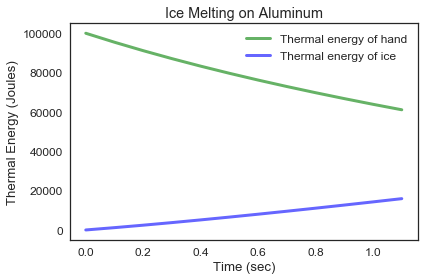

In [227]:
plot(results.thermal_energy_hand, 'g', label='Thermal energy of hand')
plot(results.thermal_energy_ice, 'b', label='Thermal energy of ice')
decorate(xlabel='Time (sec)', 
         ylabel='Thermal Energy (Joules)', 
         title='Ice Melting on Aluminum')

In [174]:
def calc_melt_time(results):
    """Returns the total runtime of simulation in seconds
    
    results: results of run_simulation

    returns: last index of TimeFrame 
    """
    return results.index[-1]

In [175]:
def sweep_material(params):
    """Sweeps through different materials to test how long ice would melt for each
    
    params:
        plate_materials: dataframe of recorded material information 
                         (name, thermal conductivity factor, 
                          specific heat capacity, density)
        surface_area: area of plate in contact with ice, in meters^2
        plate_temp: temperature of the plate, in celsius 
        thickness: thickness of the plate, in meters

    returns: DataFrame with results of sweep
    """
    
    plate_materials, surface_area, plate_temp, thickness = params
    
    thermal_conductivity_factors = plate_materials['thermal_conductivity_factor']
    specific_heat_capacities = plate_materials['specific_heat_capacity']
    
    sweep = SweepSeries()
    for i in range(0, plate_materials['material'].size):
        system_params = Params(plate_materials['material'][i],
                plate_materials=plate_materials,
                surface_area=surface_area,
                plate_temp=plate_temp,
                thickness=thickness,
                dt=.1)
        system = make_system(system_params)
        results = run_simulation(system, update_func)
        sweep[plate_materials['material'][i]] = calc_melt_time(results)
    return sweep

aluminum       0.8
nickel         1.9
marble        71.8
wood        1118.0
dtype: float64


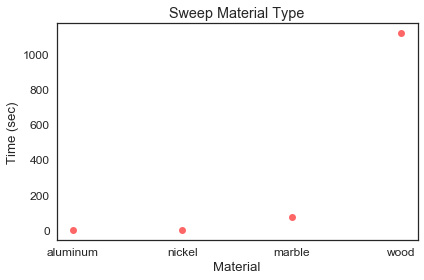

In [176]:
params = Params(plate_materials=plate_materials,
                surface_area=.05,
                plate_temp=23,
                thickness=.02)
sweep = sweep_material(params)

print(sweep)

plot(sweep, 'or')
decorate(xlabel='Material', 
         ylabel='Time (sec)', 
         title='Sweep Material Type')

In [177]:
def sweep_surface_area(params):
    """Sweeps through range of surface areas to test how long ice would melt for each
    
    params:
        material: type of material as a string
        plate_materials: dataframe of recorded material information 
                         (name, thermal conductivity factor, 
                          specific heat capacity, density)
        plate_temp: temperature of the plate, in celsius 
        thickness: thickness of the plate, in meters
        surface_area_array: list holding surface areas to test

    returns: DataFrame with results of sweep
    """
    
    material, plate_materials, plate_temp, thickness, surface_area_array = params
    sweep = SweepSeries()
    for surface_area in surface_area_array:
        system_params = Params(material=material,
                plate_materials=plate_materials,
                surface_area=surface_area,
                plate_temp=plate_temp,
                thickness=thickness,
                dt=.1)
        system = make_system(system_params)
        results = run_simulation(system, update_func)
        sweep[system.surface_area]= calc_melt_time(results)
    return sweep

0.01    4.3
0.02    2.1
0.03    1.4
0.04    1.0
0.05    0.8
dtype: float64


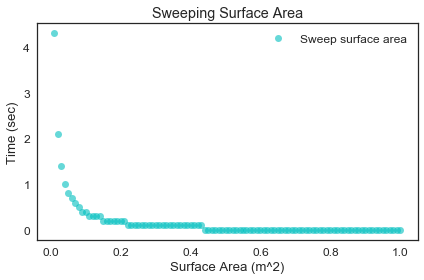

In [178]:
surface_area_array = linspace(0.01, 1, 100)

params = Params(material='aluminum',
                plate_materials=plate_materials,
                plate_temp=23,
                thickness=.02,
                surface_area_array=surface_area_array)
sweep = sweep_surface_area(params)

print(sweep.head())

plot(sweep, 'oc', label='Sweep surface area')
decorate(xlabel='Surface Area (m^2)', 
         ylabel='Time (sec)', 
         title='Sweeping Surface Area')

In [179]:
def sweep_plate_temp(params):
    """Sweeps through different plate temperatures to test how long ice would melt for each
    
    params:
        material: type of material as a string
        plate_materials: dataframe of recorded material information 
                         (name, thermal conductivity factor, 
                          specific heat capacity, density)
        surface_area: area of plate in contact with ice, in meters^2
        thickness: thickness of the plate, in meters
        plate_temp_array: list holding plate temperatures to test

    returns: DataFrame with results of sweep
    """
    
    material, plate_materials, surface_area, thickness, plate_temp_array = params
    sweep = SweepSeries()
    for plate_temp in plate_temp_array:
        system_params = Params(material=material,
                plate_materials=plate_materials,
                surface_area=surface_area,
                plate_temp=plate_temp,
                thickness=thickness,
                dt=.1)
        system = make_system(system_params)
        results = run_simulation(system, update_func)
        sweep[system.plate_temp]= calc_melt_time(results)
    return sweep

0     0.8
5     0.8
10    0.8
15    0.8
20    0.8
dtype: float64


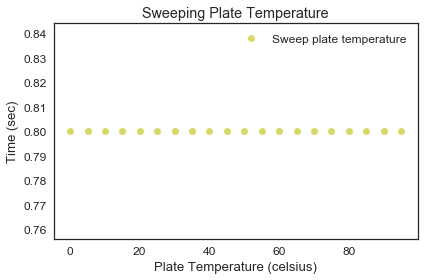

In [180]:
plate_temp_array = linrange(0, 100, 5)

params = Params(material='aluminum',
                plate_materials=plate_materials,
                surface_area=.05,
                thickness=.02,
                plate_temp_array=plate_temp_array)
sweep = sweep_plate_temp(params)

print(sweep.head())

plot(sweep, 'yo', label='Sweep plate temperature')
decorate(xlabel='Plate Temperature (celsius)', 
         ylabel='Time (sec)', 
         title='Sweeping Plate Temperature')

In [181]:
def sweep_thickness(params):
    """Sweeps through different thicknesses to test how long ice would melt for each
    
    params:
        material: type of material as a string
        plate_materials: dataframe of recorded material information 
                         (name, thermal conductivity factor, 
                          specific heat capacity, density)
        surface_area: area of plate in contact with ice, in meters^2
        plate_temp: temperature of the plate, in celsius 
        thickness_array: list holding thicknesses to test

    returns: DataFrame with results of sweep
    """
    
    material, plate_materials, surface_area, plate_temp, thickness_array = params
    sweep = SweepSeries()
    for thickness in thickness_array:
        system_params = Params(material=material,
                plate_materials=plate_materials,
                surface_area=surface_area,
                plate_temp=plate_temp,
                thickness=thickness,
                dt=.1)
        system = make_system(system_params)
        results = run_simulation(system, update_func)
        sweep[system.thickness]= calc_melt_time(results)
    return sweep

0.010000     0.4
0.062105     2.7
0.114211     5.1
0.166316     7.5
0.218421    10.0
dtype: float64


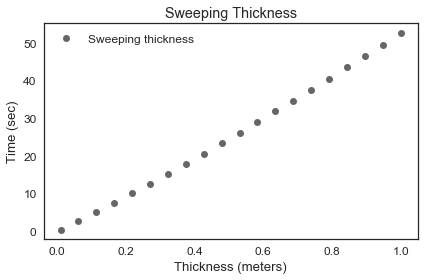

In [182]:
thickness_array = linspace(0.01, 1, 20)

params = Params(material='aluminum',
                plate_materials=plate_materials,
                surface_area=.05,
                plate_temp=23,
                thickness_array=thickness_array)
sweep = sweep_thickness(params)

print(sweep.head())

plot(sweep, 'ko', label='Sweeping thickness')
decorate(xlabel='Thickness (meters)', 
         ylabel='Time (sec)', 
         title='Sweeping Thickness')
    

Here we run a simulation of the extreme cases of each paramter to see how quickly ice could potentially melt (unrealistic scenario):

In [183]:
params = Params(material='aluminum',
                plate_materials=plate_materials,
                surface_area=1,
                plate_temp=100,
                thickness=.01,
                dt=.001)
system = make_system(params)
results = run_simulation(system, update_func)

,thermal_energy_hand,thermal_energy_ice,hand_temp,plate_temp
0.000,100000,0,37,100
0.001,100767,758.5,37.0054,99.937
0.002,101533,1517.11,37.0108,99.8741
0.003,102297,2275.83,37.0162,99.8112
0.004,103059,3034.66,37.0215,99.7484
0.005,103819,3793.6,37.0269,99.6857
0.006,104577,4552.66,37.0322,99.623
0.007,105334,5311.82,37.0375,99.5604
0.008,106089,6071.09,37.0429,99.4979
0.009,106842,6830.46,37.0482,99.4355


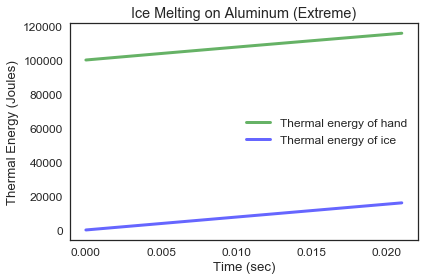

In [184]:
plot(results.thermal_energy_hand, 'g', label='Thermal energy of hand')
plot(results.thermal_energy_ice, 'b', label='Thermal energy of ice')
decorate(xlabel='Time (sec)', 
         ylabel='Thermal Energy (Joules)', 
         title='Ice Melting on Aluminum (Extreme)')